### Procesamiento de data para identificar periodos análogos

### Librerias

In [12]:
pip install openpyxl

  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached et_xmlfile-2.0.0-py3-none-any.whl.metadata (2.7 kB)
Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
Using cached et_xmlfile-2.0.0-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import glob
from pathlib import PureWindowsPath
from datetime import datetime
import re
import warnings
import os
import xlrd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import plotly.express as px

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist


from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.metrics import silhouette_score, make_scorer
from scipy.cluster.hierarchy import leaves_list


warnings.filterwarnings("ignore")
# set the max columns to none
pd.set_option('display.max_columns', None)

En esta primera parte, se replican los resultados obtenidos del análisis de conglomerados para cada una de las variables utilizando el aplicativo Infostat. Para cada variable, se realiza un análisis de conglomerados aplicando el método de clustering jerárquico, sin normalizar los datos y utilizando el método de enlace promedio. Posteriormente, de forma visual, se identifican los periodos más semejantes.

In [3]:
### Cambiar estructura de tablas

def estructura_df(df):
    df= df.copy()
    month_names = {1: 'Enero', 2: 'Febrero', 3: 'Marzo', 4: 'Abril', 5: 'Mayo', 6: 'Junio'}
    df['Mes'] =df['Mes'].map(month_names)

    df = df.set_index('Mes').transpose()
    ordered_columns = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio']
    df= df[ordered_columns]
    df = df.reset_index()
    df = df.rename(columns={'index': 'Año'})
    df.index.name = None
    df.columns.name = None
   
    return df

####################################
# Data lluvia
####################################

In [13]:
df_lluvia=pd.read_excel("D:\\OneDrive - CGIAR\\Proyectos\\AgriLAC-ICC\\Analytics\\Datos para estimación años análogos junio 2024.xlsx", sheet_name="Datos lluvias")
df_lluvia=estructura_df(df_lluvia)
df_lluvia.head()

,Año,Enero,Febrero,Marzo,Abril,Mayo,Junio
0,1998,0.0,0.0,0.0,4.8,23.8,84.8
1,1999,0.4,49.6,47.8,294.0,494.2,662.4
2,2000,12.0,12.0,7.4,21.4,319.4,405.4
3,2001,1.4,68.0,25.2,91.8,501.8,633.8
4,2002,27.0,6.8,44.4,46.8,389.0,425.5


In [14]:
#### tabla formato largo
df_melted = df_lluvia.melt(id_vars='Año', var_name='Mes', value_name='Lluvia')
df_melted

,Año,Mes,Lluvia
0,1998,Enero,0.0
1,1999,Enero,0.4
2,2000,Enero,12.0
3,2001,Enero,1.4
4,2002,Enero,27.0
...,...,...,...
157,2020,Junio,594.0
158,2021,Junio,447.8
159,2022,Junio,545.6
160,2023,Junio,474.2


####################################
### Comportamiento de la lluvia por periodo
####################################

In [5]:

meses_orden = ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio"]
df_melted['Mes'] = pd.Categorical(df_melted['Mes'], categories=meses_orden, ordered=True)

# Graficar la serie de tiempo
fig = px.line(df_melted, x='Mes', y='Lluvia', color='Año',
              labels={'Mes': 'Mes', 'Lluvia': 'Lluvia (mm)', 'Año': 'Año'},
              title='Comportamiento de Lluvias por Año')

fig.show()

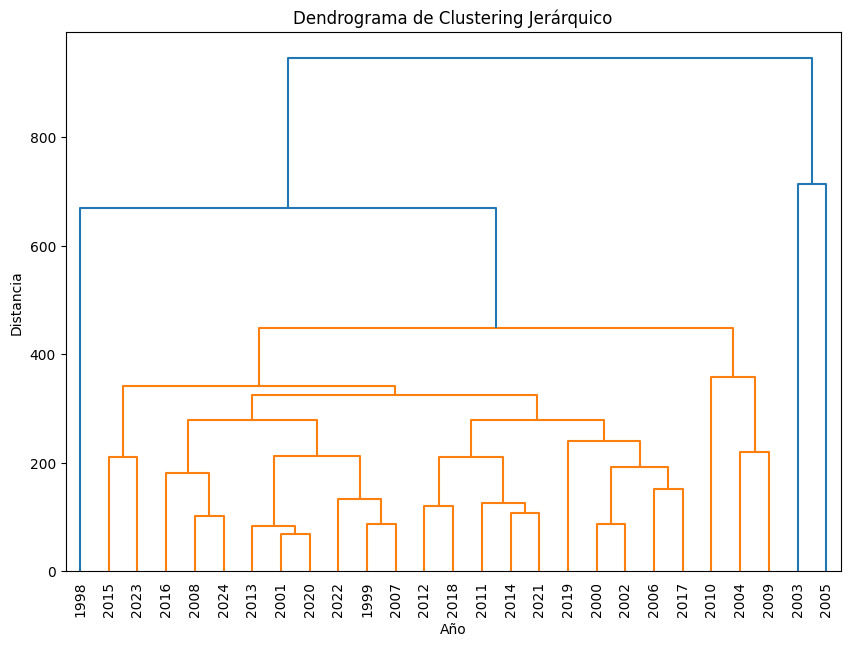

,Cluster1,Cluster2,Cluster3,Cluster4,Cluster5,Cluster6
0,1999,2004.0,2010.0,1998.0,2003.0,2005.0
1,2000,2009.0,NaN,NaN,NaN,NaN
2,2001,NaN,NaN,NaN,NaN,NaN
3,2002,NaN,NaN,NaN,NaN,NaN
4,2006,NaN,NaN,NaN,NaN,NaN
5,2007,NaN,NaN,NaN,NaN,NaN
6,2008,NaN,NaN,NaN,NaN,NaN
7,2011,NaN,NaN,NaN,NaN,NaN
8,2012,NaN,NaN,NaN,NaN,NaN
9,2013,NaN,NaN,NaN,NaN,NaN


In [15]:
# Normalizar los datos (opcional, pero recomendable)
df_scaled = df_lluvia.copy()
#df_scaled.iloc[:, 1:] = (df_scaled.iloc[:, 1:] - df_scaled.iloc[:, 1:].mean()) / df_scaled.iloc[:, 1:].std()

# Calcular la matriz de distancias
dist_matrix = pdist(df_scaled.iloc[:, 1:], metric='euclidean')

# Aplicar el algoritmo de clustering jerárquico
Z = linkage(dist_matrix, method='average')

# Dibujar el dendrograma
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=df_lluvia['Año'].values, leaf_rotation=90)
plt.title('Dendrograma de Clustering Jerárquico')
plt.xlabel('Año')
plt.ylabel('Distancia')
plt.show()


leaves_order = leaves_list(Z)

# Ordenar los años de acuerdo al orden en el dendrograma
ordered_years_lluvia = df_lluvia['Año'].values[leaves_order]




#  criterio para el número máximo de clusters
max_clusters = 6 # máximo de 5 clusters
clusters = fcluster(Z, max_clusters, criterion='maxclust')

df_lluvia['Cluster'] = clusters

df_lluvia[['Año', 'Cluster']]


# Agrupar los años por cada cluster
cluster_groups = df_lluvia.groupby('Cluster')['Año'].apply(list).reset_index()


cluster_results = {}
for index, row in cluster_groups.iterrows():
    cluster_results[f'Cluster{row["Cluster"]}'] = row['Año']

lluvia= pd.DataFrame(dict([(k, pd.Series(v)) for k, v in cluster_results.items()]))


lluvia

In [18]:
ordered_years_lluvia = df_lluvia['Año'].values[leaves_order]
ranking_lluvia= pd.DataFrame({
    'Año': ordered_years_lluvia,
    'Orden': range(1, len(ordered_years_lluvia)+1)
})
ranking_lluvia

,Año,Orden
0,1998,1
1,2015,2
2,2023,3
3,2016,4
4,2008,5
5,2024,6
6,2013,7
7,2001,8
8,2020,9
9,2022,10


In [88]:
# Transformar tabla para obtener columnas "Año" y "Cluster"
clusters_melted = lluvia.melt(var_name='ClusterLluvia', value_name='Año').dropna().reset_index(drop=True)


### Resultado por el programa de  Infostat (lluvia) 6 clusters

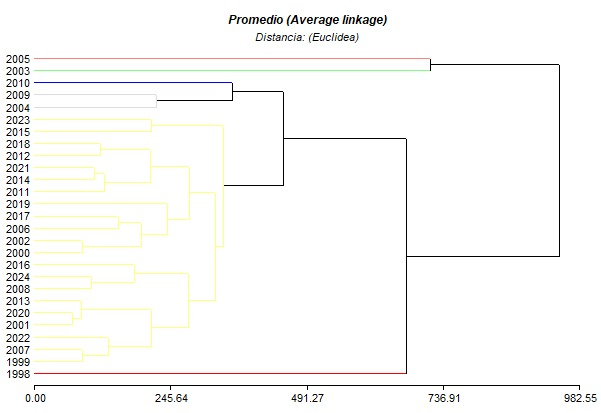

In [97]:
df_lluvia_clusters = df_lluvia.merge(clusters_melted, on='Año', how='left')
df_lluvia_clusters.head()

,Año,Enero,Febrero,Marzo,Abril,Mayo,Junio,ClusterLluvia
0,1998,0.0,0.0,0.0,4.8,23.8,84.8,Cluster4
1,1999,0.4,49.6,47.8,294.0,494.2,662.4,Cluster1
2,2000,12.0,12.0,7.4,21.4,319.4,405.4,Cluster1
3,2001,1.4,68.0,25.2,91.8,501.8,633.8,Cluster1
4,2002,27.0,6.8,44.4,46.8,389.0,425.5,Cluster1


In [90]:
df_melted = df_lluvia_clusters.melt(id_vars=['Año', 'ClusterLluvia'], 
                           var_name='Mes', 
                           value_name='Lluvia')
df_melted

,Año,ClusterLluvia,Mes,Lluvia
0,1998,Cluster4,Enero,0.0
1,1999,Cluster1,Enero,0.4
2,2000,Cluster1,Enero,12.0
3,2001,Cluster1,Enero,1.4
4,2002,Cluster1,Enero,27.0
...,...,...,...,...
157,2020,Cluster1,Junio,594.0
158,2021,Cluster1,Junio,447.8
159,2022,Cluster1,Junio,545.6
160,2023,Cluster1,Junio,474.2


In [92]:

meses_orden = ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio"]
df_melted['Mes'] = pd.Categorical(df_melted['Mes'], categories=meses_orden, ordered=True)

# Graficar la serie de tiempo
fig = px.box(df_melted, x='Mes', y='Lluvia', color='ClusterLluvia', 
              labels={'Mes': 'Mes', 'Lluvia': 'Lluvia (mm)', 'ClusterLluvia': 'Cluster'},
              title='Comportamiento de Lluvias por Cluster')

fig.show()

#### Interpretación

* Cluster 1: 1999,2000,2001,2002,2006,2007,2008,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
* Cluster 2: 2004,2009
* Cluster 3: 2010
* Cluster 4: 1998
* Cluster 5: 2003
* Cluster 6: 2005

### Caracterización de clusters lluvia

* Cluster 1: Es el más grande, abarcando la mayoría de los años desde 1999 hasta 2024. Representa el patrón de lluvia más común o "normal" para la región.
* Cluster 2 (2004, 2009): Muestra un patrón de lluvia distinto, con un pico más pronunciado en mayo comparado con el Cluster 1.
* Cluster 3 (2010): Presenta el segundo nivel más alto de precipitación, especialmente notable en abril y mayo.
* Cluster 4 (1998): Año con el patrón de lluvia más bajo y constante a lo largo de los meses.
* Cluster 5 (2003): el cluster con la mayor cantidad de lluvia, mostrando un pico muy pronunciado en mayo y manteniendo niveles altos en junio. Representa el año con el patrón de precipitación más extremo.
* Cluster 6 (2005): Muestra un patrón intermedio, con un aumento significativo en mayo pero no tan extremo como los Clusters 3 y 5.

### Asignación de valores a los clusters

* Cluster 1 (Normal): 1 (Patrón común, normal)
* Cluster 2 (Pico en mayo): 3 (Pico notable en mayo)
* Cluster 3 (Alto en abril y mayo): 4 (Segundo nivel más alto de precipitación)
* Cluster 4 (Constante y bajo): 2 (Patrón más bajo y constante)
* Cluster 5 (Extremo en mayo): 5 (Mayor cantidad de lluvia, patrón extremo)
* Cluster 6 (Intermedio): 3 (Aumento significativo en mayo)

en la asignación de valores a los clusters se consideró la severidad y las características distintivas de cada cluster. Los valores más altos se asignaron a los clusters con patrones más extremos o significativos, mientras que los valores más bajos se asignaron a los clusters que representan condiciones más comunes o menos extremas.

####################################
# Data Atlantico
####################################

In [22]:
df_atlantico=pd.read_excel("D:\\OneDrive - CGIAR\\Proyectos\\AgriLAC-ICC\\Analytics\\Datos para estimación años análogos junio 2024.xlsx", sheet_name="Datos Atlántico")
df_atlantico=estructura_df(df_atlantico)
df_atlantico.head() 

,Año,Enero,Febrero,Marzo,Abril,Mayo,Junio
0,1998,0.39,-0.11,0.87,-0.68,-1.32,-2.72
1,1999,0.77,0.29,0.23,-0.95,0.92,1.12
2,2000,0.60,1.70,0.77,-0.03,1.58,-0.03
3,2001,0.25,0.45,-1.26,0.00,-0.02,-0.20
4,2002,0.44,1.10,0.69,1.18,-0.22,0.38


In [23]:
#### tabla formato largo
df_melted = df_atlantico.melt(id_vars='Año', var_name='Mes', value_name='a_atlantico')
df_melted

,Año,Mes,a_atlantico
0,1998,Enero,0.39
1,1999,Enero,0.77
2,2000,Enero,0.60
3,2001,Enero,0.25
4,2002,Enero,0.44
...,...,...,...
157,2020,Junio,-0.15
158,2021,Junio,0.77
159,2022,Junio,-0.12
160,2023,Junio,-0.58


In [9]:

meses_orden = ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio"]
df_melted['Mes'] = pd.Categorical(df_melted['Mes'], categories=meses_orden, ordered=True)

# Graficar la serie de tiempo
fig = px.line(df_melted, x='Mes', y='a_atlantico', color='Año',
              labels={'Mes': 'Mes', 'a_atlantico': 'anomalia', 'Año': 'Año'},
              title='Comportamiento de anomalia STMA')

fig.show()

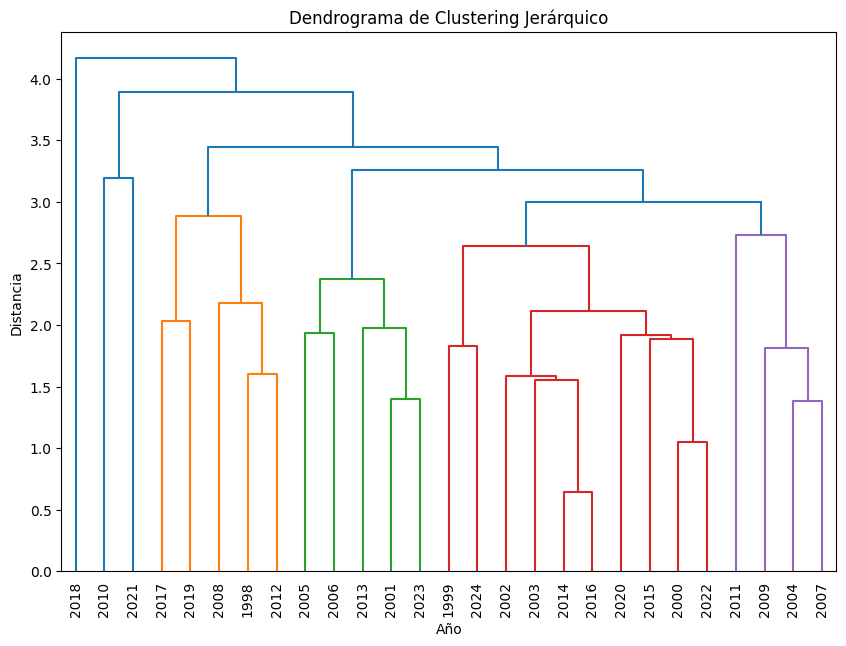

,Cluster1,Cluster2,Cluster3,Cluster4,Cluster5,Cluster6
0,2010.0,2021.0,1998.0,2001.0,1999,2018.0
1,NaN,NaN,2008.0,2005.0,2000,NaN
2,NaN,NaN,2012.0,2006.0,2002,NaN
3,NaN,NaN,2017.0,2013.0,2003,NaN
4,NaN,NaN,2019.0,2023.0,2004,NaN
5,NaN,NaN,NaN,NaN,2007,NaN
6,NaN,NaN,NaN,NaN,2009,NaN
7,NaN,NaN,NaN,NaN,2011,NaN
8,NaN,NaN,NaN,NaN,2014,NaN
9,NaN,NaN,NaN,NaN,2015,NaN


In [24]:

df_scaled = df_atlantico.copy()
#df_scaled.iloc[:, 1:] = (df_scaled.iloc[:, 1:] - df_scaled.iloc[:, 1:].mean()) / df_scaled.iloc[:, 1:].std()

# Calcular la matriz de distancias
dist_matrix = pdist(df_scaled.iloc[:, 1:], metric='euclidean')

# Aplicar el algoritmo de clustering jerárquico
Z = linkage(dist_matrix, method='average')

# Dibujar el dendrograma
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=df_atlantico['Año'].values, leaf_rotation=90)
plt.title('Dendrograma de Clustering Jerárquico')
plt.xlabel('Año')
plt.ylabel('Distancia')
plt.show()



leaves_order = leaves_list(Z)

# Ordenar los años de acuerdo al orden en el dendrograma
ordered_years_atlantico = df_atlantico['Año'].values[leaves_order]




#  criterio para el número máximo de clusters
max_clusters = 6 # máximo de 5 clusters
clusters = fcluster(Z, max_clusters, criterion='maxclust')

df_atlantico['Cluster'] = clusters

df_atlantico[['Año', 'Cluster']]


# Agrupar los años por cada cluster
cluster_groups = df_atlantico.groupby('Cluster')['Año'].apply(list).reset_index()


cluster_results = {}
for index, row in cluster_groups.iterrows():
    cluster_results[f'Cluster{row["Cluster"]}'] = row['Año']

atlantico = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in cluster_results.items()]))


atlantico

In [25]:
ordered_years_atlantico = df_atlantico['Año'].values[leaves_order]


In [26]:
ranking_atlantico = pd.DataFrame({
    'Año': ordered_years_atlantico,
    'Orden': range(1, len(ordered_years_atlantico)+1)
})

In [27]:
ranking_atlantico 

,Año,Orden
0,2018,1
1,2010,2
2,2021,3
3,2017,4
4,2019,5
5,2008,6
6,1998,7
7,2012,8
8,2005,9
9,2006,10


### Resultado por el programa de  Infostat (Atlantico) 6 clusters

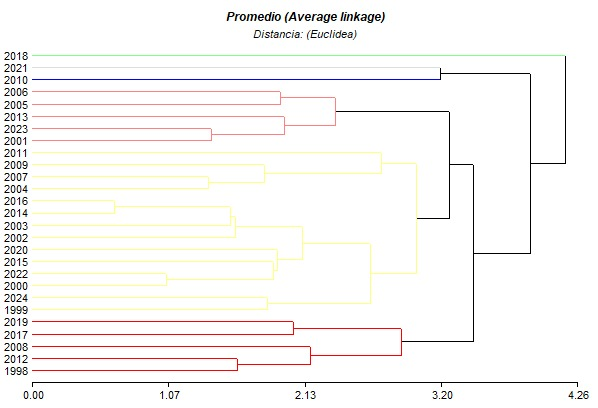

In [103]:
# Transformar tabla para obtener columnas "Año" y "Cluster"
clusters_atlantico = atlantico.melt(var_name='Clusteratlantico', value_name='Año').dropna().reset_index(drop=True)

In [104]:
df_atlantico_clusters = df_atlantico.merge(clusters_atlantico , on='Año', how='left')
df_atlantico_clusters

,Año,Enero,Febrero,Marzo,Abril,Mayo,Junio,Cluster,Clusteratlantico
0,1998,0.39,-0.11,0.87,-0.68,-1.32,-2.72,3,Cluster3
1,1999,0.77,0.29,0.23,-0.95,0.92,1.12,5,Cluster5
2,2000,0.60,1.70,0.77,-0.03,1.58,-0.03,5,Cluster5
3,2001,0.25,0.45,-1.26,0.00,-0.02,-0.20,4,Cluster4
4,2002,0.44,1.10,0.69,1.18,-0.22,0.38,5,Cluster5
5,2003,0.16,0.62,0.32,-0.18,0.01,-0.07,5,Cluster5
6,2004,-0.29,-0.14,1.02,1.15,0.19,-0.89,5,Cluster5
7,2005,1.52,-0.06,-1.83,-0.30,-1.25,-0.05,4,Cluster4
8,2006,1.27,-0.51,-1.28,1.24,-1.14,0.84,4,Cluster4
9,2007,0.22,-0.47,1.44,0.17,0.66,-1.31,5,Cluster5


In [106]:
df_melted = df_atlantico_clusters.melt(id_vars=['Año', 'Clusteratlantico'], 
                           var_name='Mes', 
                           value_name='a_atlantico')
df_melted

,Año,Clusteratlantico,Mes,a_atlantico
0,1998,Cluster3,Enero,0.39
1,1999,Cluster5,Enero,0.77
2,2000,Cluster5,Enero,0.60
3,2001,Cluster4,Enero,0.25
4,2002,Cluster5,Enero,0.44
...,...,...,...,...
184,2020,Cluster5,Cluster,5.00
185,2021,Cluster2,Cluster,2.00
186,2022,Cluster5,Cluster,5.00
187,2023,Cluster4,Cluster,4.00


In [110]:
# Definir el orden de los clusters
clusters_orden = ["Cluster1", "Cluster2", "Cluster3", "Cluster4", "Cluster5", "Cluster6"]
df_melted['Clusteratlantico'] = pd.Categorical(df_melted['Clusteratlantico'], categories=clusters_orden, ordered=True)

# Ordenar los meses
meses_orden = ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio"]
df_melted['Mes'] = pd.Categorical(df_melted['Mes'], categories=meses_orden, ordered=True)

# Crear el boxplot
fig = px.box(df_melted, x='Mes', y='a_atlantico', color='Clusteratlantico', 
             labels={'Mes': 'Mes', 'a_atlantico': 'Anomalia_atlantico', 'Clusteratlantico': 'Cluster'},
             title='Comportamiento de anomalias atlantico')

# Mostrar la gráfica
fig.show()

# Caracterización de clusters atlantico  

### Entendimiento 
Las anomalías de temperatura de los océanos se interpretan de la siguiente manera:

* Definición: Una anomalía es la desviación de la temperatura observada respecto a un promedio a largo plazo para esa ubicación y época del año.


Valores:

* Positivos: Indican temperaturas más cálidas que el promedio.
* Negativos: Indican temperaturas más frías que el promedio.
* Cero: Representa temperaturas cercanas al promedio histórico.


Magnitud: Valores más alejados de cero (en ambas direcciones) indican anomalías más fuertes.


* Importancia:

Ayudan a identificar patrones climáticos como El Niño o La Niña.
Son indicadores de cambios climáticos a largo plazo.
Pueden influir en patrones meteorológicos, ecosistemas marinos y ciclos de pesca.

### Clusters
* Cluster 1: 2010
* Cluster 2: 2021
* Cluster 3: 1998,2008,2012,2017,2019
* Cluster 4: 2001,2005,2006,2013,2023
* Cluster 5: 1999,2000,2002,2003,2004,2005,2007,2009,2011,2014,2015,2016,2020,2022,2024
* Cluster 6: 2018

### Interpretación 
* Cluster 5: Es el más grande, abarcando la mayoría de los años desde 1999 hasta 2024. Representa el patrón más común o "normal" de anomalías, con variaciones relativamente pequeñas alrededor de cero.
* Cluster 3 (1998, 2008, 2012, 2017, 2019): Muestra anomalías positivas más pronunciadas, especialmente en los meses de abril a junio. Esto indica años con temperaturas superficiales del Atlántico más cálidas de lo normal.
* Cluster 4 (2001, 2005, 2006, 2013, 2023): Presenta un patrón con anomalías negativas más marcadas en marzo y abril, sugiriendo temperaturas más frías de lo normal en esos meses.
* Cluster 1 (2010): Año único con fuertes anomalias sugiriendo temperaturas más frías de lo normal, se marca un pico de temperaturas mas frias en Febrero
* Cluster 2 (2021): Otro año único con un patrón distinto, mostrando anomalías negativas al principio del año y un fuerte aumento hacia anomalías positivas en mayo y junio.
* Cluster 6 (2018): Presenta un patrón particular con una fuerte anomalía negativa en marzo, indicando un enfriamiento inusual del Atlántico en ese mes.

### Asignación de valores a los clusters

* Cluster 1 (Frío en febrero): 4 (Fuertes anomalías frías)
* Cluster 2 (Aumento en mayo y junio): 3 (Patrón distinto con aumento fuerte)
* Cluster 3 (Cálido de abril a junio): 5 (Anomalías positivas pronunciadas)
* Cluster 4 (Frío en marzo y abril): 3 (Anomalías negativas marcadas)
* Cluster 5 (Normal): 1 (Patrón común, normal)
* Cluster 6 (Frío en marzo): 4 (Fuerte anomalía negativa en marzo)

####################################
# Data pacifico
####################################

In [28]:
df_pacifico= pd.read_excel("D:\\OneDrive - CGIAR\\Proyectos\\AgriLAC-ICC\\Analytics\\Datos para estimación años análogos junio 2024.xlsx", sheet_name="Datos pacífico")
df_pacifico=estructura_df(df_pacifico)
df_pacifico

,Año,Enero,Febrero,Marzo,Abril,Mayo,Junio
0,1998,2.2,1.9,1.4,1.0,0.50,-0.10
1,1999,-1.5,-1.3,-1.1,-1.0,-1.00,-1.00
2,2000,-1.7,-1.4,-1.1,-0.8,-0.70,-0.60
3,2001,-0.7,-0.5,-0.4,-0.3,-0.30,-0.10
4,2002,-0.1,0.0,0.1,0.2,0.40,0.70
5,2003,0.9,0.6,0.4,0.0,-0.30,-0.20
6,2004,0.4,0.3,0.2,0.2,0.20,0.30
7,2005,0.6,0.6,0.4,0.4,0.30,0.10
8,2006,-0.9,-0.8,-0.6,-0.4,-0.10,0.00
9,2007,0.7,0.2,-0.1,-0.3,-0.40,-0.50


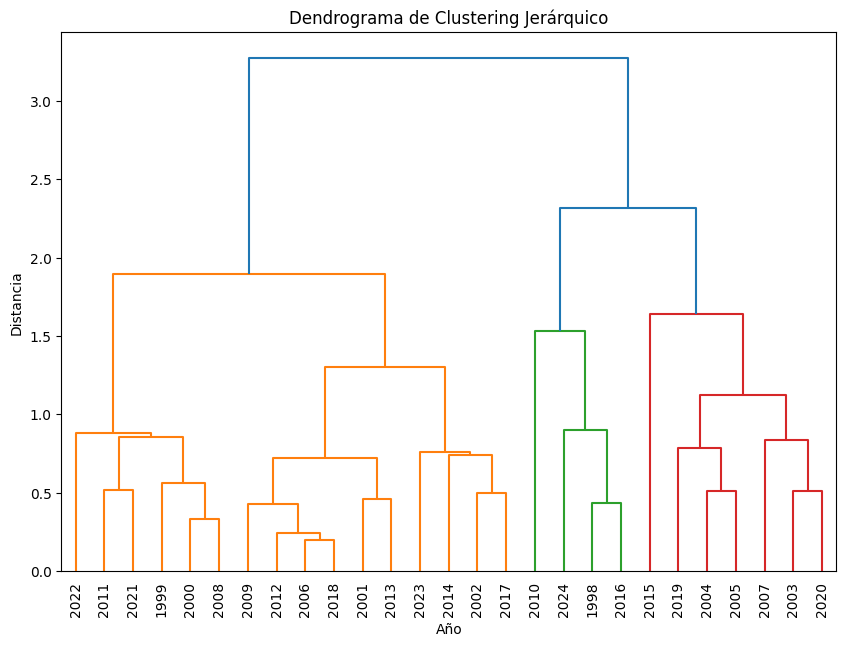

,Cluster1,Cluster2,Cluster3,Cluster4,Cluster5,Cluster6
0,1999.0,2001,1998.0,2010.0,2003.0,2015.0
1,2000.0,2002,2016.0,NaN,2004.0,NaN
2,2008.0,2006,2024.0,NaN,2005.0,NaN
3,2011.0,2009,NaN,NaN,2007.0,NaN
4,2021.0,2012,NaN,NaN,2019.0,NaN
5,2022.0,2013,NaN,NaN,2020.0,NaN
6,NaN,2014,NaN,NaN,NaN,NaN
7,NaN,2017,NaN,NaN,NaN,NaN
8,NaN,2018,NaN,NaN,NaN,NaN
9,NaN,2023,NaN,NaN,NaN,NaN


In [29]:
# Normalizar los datos (opcional, pero recomendable)
df_scaled = df_pacifico.copy()
#df_scaled.iloc[:, 1:] = (df_scaled.iloc[:, 1:] - df_scaled.iloc[:, 1:].mean()) / df_scaled.iloc[:, 1:].std()

# Calcular la matriz de distancias
dist_matrix = pdist(df_scaled.iloc[:, 1:], metric='euclidean')

# Aplicar el algoritmo de clustering jerárquico
Z = linkage(dist_matrix, method='average')

# Dibujar el dendrograma
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=df_pacifico['Año'].values, leaf_rotation=90)
plt.title('Dendrograma de Clustering Jerárquico')
plt.xlabel('Año')
plt.ylabel('Distancia')
plt.show()



leaves_order = leaves_list(Z)

# Ordenar los años de acuerdo al orden en el dendrograma
ordered_years_pacifico = df_pacifico['Año'].values[leaves_order]




#  criterio para el número máximo de clusters
max_clusters = 6  # máximo de clusters
clusters = fcluster(Z, max_clusters, criterion='maxclust')

df_pacifico['Cluster'] = clusters

df_pacifico[['Año', 'Cluster']]


# Agrupar los años por cada cluster
cluster_groups = df_pacifico.groupby('Cluster')['Año'].apply(list).reset_index()


cluster_results = {}
for index, row in cluster_groups.iterrows():
    cluster_results[f'Cluster{row["Cluster"]}'] = row['Año']

pacifico = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in cluster_results.items()]))

pacifico

In [30]:
ordered_years_pacifico = df_pacifico['Año'].values[leaves_order]
ranking_pacifico= pd.DataFrame({
    'Año': ordered_years_pacifico,
    'Orden': range(1, len(ordered_years_pacifico)+1)
})
ranking_pacifico

,Año,Orden
0,2022,1
1,2011,2
2,2021,3
3,1999,4
4,2000,5
5,2008,6
6,2009,7
7,2012,8
8,2006,9
9,2018,10


### Resultado por el programa de  Infostat

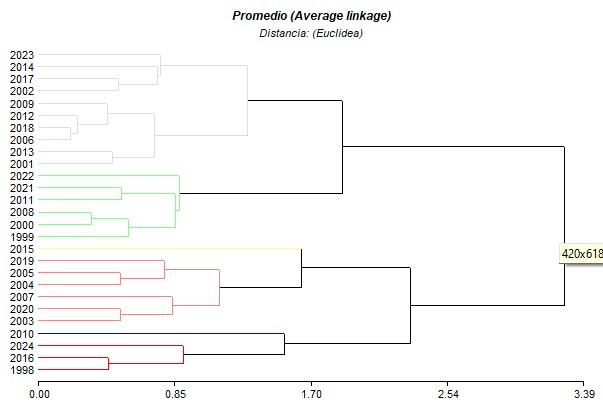

In [15]:
#### tabla formato largo
df_melted = df_pacifico.melt(id_vars='Año', var_name='Mes', value_name='a_pacifico')
df_melted

,Año,Mes,a_pacifico
0,1998,Enero,2.2
1,1999,Enero,-1.5
2,2000,Enero,-1.7
3,2001,Enero,-0.7
4,2002,Enero,-0.1
...,...,...,...
184,2020,Cluster,5.0
185,2021,Cluster,1.0
186,2022,Cluster,1.0
187,2023,Cluster,2.0


In [16]:

meses_orden = ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio"]
df_melted['Mes'] = pd.Categorical(df_melted['Mes'], categories=meses_orden, ordered=True)

# Graficar la serie de tiempo
fig = px.line(df_melted, x='Mes', y='a_pacifico', color='Año',
              labels={'Mes': 'Mes', 'a_pacifico': 'anomalia', 'Año': 'Año'},
              title='Comportamiento de anomalia temperatura oceano pacifico')

fig.show()

In [141]:
meses_orden = ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio"]
df_melted['Mes'] = pd.Categorical(df_melted['Mes'], categories=meses_orden, ordered=True)

# Graficar la serie de tiempo
fig = px.box(df_melted, x='Mes', y='a_pacifico', color='ClusterPacifico', 
              labels={'Mes': 'Mes', 'a_pacifico': 'anomalia pacifico', 'ClusterPacifico': 'Cluster'},
              title='Comportamiento de anomalias pacifico por Cluster')

fig.show()

# Caracterización de clusters pacifico

### Entendimiento 
Las anomalías de temperatura de los océanos se interpretan de la siguiente manera:

* Definición: Una anomalía es la desviación de la temperatura observada respecto a un promedio a largo plazo para esa ubicación y época del año.


Valores:

* Positivos: Indican temperaturas más cálidas que el promedio.
* Negativos: Indican temperaturas más frías que el promedio.
* Cero: Representa temperaturas cercanas al promedio histórico.


Magnitud: Valores más alejados de cero (en ambas direcciones) indican anomalías más fuertes.


* Importancia:

Ayudan a identificar patrones climáticos como El Niño o La Niña.
Son indicadores de cambios climáticos a largo plazo.
Pueden influir en patrones meteorológicos, ecosistemas marinos y ciclos de pesca.

### Clusters
* Cluster 1: 1999,2000,2008,2011,2021,2022
* Cluster 2: 2001,2002,2006,2009,2012,2013,2014,2017,2018,2023
* Cluster 3: 1998, 2016,2024 
* Cluster 4: 2010
* Cluster 5: 2003,2004,2005,2007,2019,2020
* Cluster 6: 2015

### Interpretación 
* Cluster 1: Este grupo muestra anomalías mayormente negativas durante todo el año, con una ligera tendencia al calentamiento hacia junio. Estos años probablemente representan condiciones de La Niña leve o neutras.
* Cluster 2: Este cluster exhibe condiciones casi neutrales, con anomalías cercanas a cero. Hay una ligera tendencia al calentamiento de enero a junio.
* Cluster 3: Este grupo muestra fuertes anomalías positivas durante todo el período, particularmente en los primeros meses. Estos años probablemente representan condiciones fuertes de El Niño.
* Cluster 4: Este año único muestra un patrón singular con anomalías positivas muy altas, especialmente de enero a abril, sugiriendo un evento de El Niño excepcionalmente fuerte.
* Cluster 5: Este cluster muestra anomalías ligeramente positivas, con más variabilidad que el Cluster 2. Estos podrían representar condiciones de El Niño débiles a moderadas.
* Cluster 6: Otro cluster de un solo año, que muestra anomalías moderadamente positivas que aumentan hacia junio. Esto probablemente representa el desarrollo de un evento significativo de El Niño.

### Asignación de valores a los clusters

* Cluster 1 (La Niña leve/neutra): 2 (Anomalías negativas leves)
* Cluster 2 (Neutro): 1 (Anomalías cercanas a cero)
* Cluster 3 (El Niño fuerte): 5 (Fuertes anomalías positivas)
* Cluster 4 (El Niño excepcionalmente fuerte): 6 (Anomalías positivas muy altas)
* Cluster 5 (El Niño débil/moderado): 3 (Anomalías ligeramente positivas)
* Cluster 6 (El Niño significativo): 4 (Anomalías moderadamente positivas)


###############################################################################
# Ponderación de clusters
###############################################################################

\begin{equation}
Z = M_1 + M_2 + M_3
\end{equation}

\begin{equation}
M = (N - n) \times p
\end{equation}

* M: Factor de ponderación.
* N: Cantidad de eventos.
* n: Posición con respecto al año actual (2024).
* p: Peso.

Peso de las variables
* Lluvia (L): p = 0.4
* Atlántico (A): p = 0.25
* Pacífico (P): p = 0.35


In [31]:
# Número total de eventos
N = len(ranking_lluvia)

# Asignar pesos
pesos = {
    'lluvia': 0.4,
    'atlantico': 0.25,
    'pacifico': 0.35
}

# Renombrar columnas por claridad
ranking_lluvia = ranking_lluvia.rename(columns={'Orden': 'orden_lluvia'})
ranking_atlantico = ranking_atlantico.rename(columns={'Orden': 'orden_atlantico'})
ranking_pacifico = ranking_pacifico.rename(columns={'Orden': 'orden_pacifico'})

# Unir los tres rankings por Año
ranking_total = ranking_lluvia.merge(ranking_atlantico, on='Año').merge(ranking_pacifico, on='Año')

# Calcular M para cada componente
ranking_total['M_lluvia'] = (N - ranking_total['orden_lluvia']) * pesos['lluvia']
ranking_total['M_atlantico'] = (N - ranking_total['orden_atlantico']) * pesos['atlantico']
ranking_total['M_pacifico'] = (N - ranking_total['orden_pacifico']) * pesos['pacifico']

# Calcular Z
ranking_total['Z'] = ranking_total['M_lluvia'] + ranking_total['M_atlantico'] + ranking_total['M_pacifico']

# Ordenar por Z (mayor Z significa más parecido al año actual)
ranking_final = ranking_total.sort_values(by='Z', ascending=False).reset_index(drop=True)

# Resultado
ranking_final[['Año', 'Z']]

,Año,Z
0,2008,21.40
1,2021,18.40
2,1998,18.20
3,2023,18.00
4,1999,17.70
5,2018,17.65
6,2013,17.25
7,2012,17.00
8,2001,16.95
9,2022,16.90


####################################################################################################################################################################################################################################

# Segunda parte- Propuesta

### Unir las tres bases de datos

In [32]:
df = pd.merge(df_atlantico, df_pacifico, on='Año', suffixes=('_atlantico', '_pacifico'))


In [33]:
df = pd.merge(df, df_lluvia, on='Año', suffixes=('', '_lluvia'))

In [34]:
columns_to_rename = {
    'Enero': 'Enero_lluvia',
    'Febrero': 'Febrero_lluvia',
    'Marzo': 'Marzo_lluvia',
    'Abril': 'Abril_lluvia',
    'Mayo': 'Mayo_lluvia',
    'Junio': 'Junio_lluvia'
}

df.rename(columns=columns_to_rename, inplace=True)
df

,Año,Enero_atlantico,Febrero_atlantico,Marzo_atlantico,Abril_atlantico,Mayo_atlantico,Junio_atlantico,Cluster_atlantico,Enero_pacifico,Febrero_pacifico,Marzo_pacifico,Abril_pacifico,Mayo_pacifico,Junio_pacifico,Cluster_pacifico,Enero_lluvia,Febrero_lluvia,Marzo_lluvia,Abril_lluvia,Mayo_lluvia,Junio_lluvia,Cluster
0,1998,0.39,-0.11,0.87,-0.68,-1.32,-2.72,3,2.2,1.9,1.4,1.0,0.50,-0.10,3,0.0,0.0,0.0,4.8,23.8,84.8,4
1,1999,0.77,0.29,0.23,-0.95,0.92,1.12,5,-1.5,-1.3,-1.1,-1.0,-1.00,-1.00,1,0.4,49.6,47.8,294.0,494.2,662.4,1
2,2000,0.60,1.70,0.77,-0.03,1.58,-0.03,5,-1.7,-1.4,-1.1,-0.8,-0.70,-0.60,1,12.0,12.0,7.4,21.4,319.4,405.4,1
3,2001,0.25,0.45,-1.26,0.00,-0.02,-0.20,4,-0.7,-0.5,-0.4,-0.3,-0.30,-0.10,2,1.4,68.0,25.2,91.8,501.8,633.8,1
4,2002,0.44,1.10,0.69,1.18,-0.22,0.38,5,-0.1,0.0,0.1,0.2,0.40,0.70,2,27.0,6.8,44.4,46.8,389.0,425.5,1
5,2003,0.16,0.62,0.32,-0.18,0.01,-0.07,5,0.9,0.6,0.4,0.0,-0.30,-0.20,5,0.0,39.7,85.6,283.3,1260.8,1122.0,5
6,2004,-0.29,-0.14,1.02,1.15,0.19,-0.89,5,0.4,0.3,0.2,0.2,0.20,0.30,5,12.0,24.6,108.4,70.9,757.6,505.8,2
7,2005,1.52,-0.06,-1.83,-0.30,-1.25,-0.05,4,0.6,0.6,0.4,0.4,0.30,0.10,5,34.0,1.8,60.0,162.2,581.0,1290.8,6
8,2006,1.27,-0.51,-1.28,1.24,-1.14,0.84,4,-0.9,-0.8,-0.6,-0.4,-0.10,0.00,2,23.7,0.0,0.0,196.0,433.0,289.3,1
9,2007,0.22,-0.47,1.44,0.17,0.66,-1.31,5,0.7,0.2,-0.1,-0.3,-0.40,-0.50,5,0.0,18.0,44.2,265.2,484.8,587.4,1


### Propuesta de método métrica maape

In [35]:
# Separar los valores observados (2024)
observed_2024 = df[df['Año'] == 2024]

# Valores observados para cada categoría en 2024
atlantic_2024 = observed_2024[['Enero_atlantico', 'Febrero_atlantico', 'Marzo_atlantico', 'Abril_atlantico', 'Mayo_atlantico', 'Junio_atlantico']].values.flatten()
pacific_2024 = observed_2024[['Enero_pacifico', 'Febrero_pacifico', 'Marzo_pacifico', 'Abril_pacifico', 'Mayo_pacifico', 'Junio_pacifico']].values.flatten()
precip_2024 = observed_2024[['Enero_lluvia', 'Febrero_lluvia', 'Marzo_lluvia', 'Abril_lluvia', 'Mayo_lluvia', 'Junio_lluvia']].values.flatten()


In [36]:

# Filtrar la tabla para excluir 2024
df_no_2024 = df[df['Año'] != 2024]


In [37]:

# Pesos para cada categoría
weights = {
    'atlantico': 0.25,
    'pacifico': 0.35,
    'lluvia': 0.40
}

In [38]:


# Función para calcular MAAPE
def calculate_maape(observed, predicted):
    observed = np.where(observed == 0, 1e-6, observed)  # Reemplazar ceros
    return np.mean(np.arctan(np.abs((observed - predicted) / observed)))

# Almacenar los resultados de MAAPE ponderado
maape_weighted_results = {}

# Iterar sobre cada año (excluyendo 2024)
for index, row in df_no_2024.iterrows():
    year = row['Año']
    
    # MAAPE para las tres categorías (Atlántico, Pacífico, Lluvia)
    maape_atlantic = calculate_maape(atlantic_2024, row[['Enero_atlantico', 'Febrero_atlantico', 'Marzo_atlantico', 'Abril_atlantico', 'Mayo_atlantico', 'Junio_atlantico']].values)
    maape_pacific = calculate_maape(pacific_2024, row[['Enero_pacifico', 'Febrero_pacifico', 'Marzo_pacifico', 'Abril_pacifico', 'Mayo_pacifico', 'Junio_pacifico']].values)
    maape_precip = calculate_maape(precip_2024, row[['Enero_lluvia', 'Febrero_lluvia', 'Marzo_lluvia', 'Abril_lluvia', 'Mayo_lluvia', 'Junio_lluvia']].values)
    
    # Cálculo del MAAPE ponderado
    maape_total = (weights['atlantico'] * maape_atlantic + 
                   weights['pacifico'] * maape_pacific + 
                   weights['lluvia'] * maape_precip)
    
    # Guardar el MAAPE ponderado para cada año
    maape_weighted_results[year] = maape_total

# Ordenar los resultados por MAAPE ponderado (menor a mayor)
maape_sorted = sorted(maape_weighted_results.items(), key=lambda x: x[1])

# Mostrar los resultados ordenados
for year, maape in maape_sorted:
    print(f"Año {year} - MAAPE Ponderado: {maape:.4f}")

Año 1998.0 - MAAPE Ponderado: 0.6760
Año 2016.0 - MAAPE Ponderado: 0.7009
Año 2002.0 - MAAPE Ponderado: 0.7795
Año 2017.0 - MAAPE Ponderado: 0.7831
Año 2019.0 - MAAPE Ponderado: 0.7880
Año 2023.0 - MAAPE Ponderado: 0.7887
Año 2020.0 - MAAPE Ponderado: 0.7956
Año 2015.0 - MAAPE Ponderado: 0.8068
Año 2005.0 - MAAPE Ponderado: 0.8162
Año 2001.0 - MAAPE Ponderado: 0.8443
Año 2010.0 - MAAPE Ponderado: 0.8563
Año 2007.0 - MAAPE Ponderado: 0.8586
Año 2003.0 - MAAPE Ponderado: 0.8677
Año 2014.0 - MAAPE Ponderado: 0.8709
Año 2006.0 - MAAPE Ponderado: 0.9012
Año 2004.0 - MAAPE Ponderado: 0.9055
Año 2008.0 - MAAPE Ponderado: 0.9131
Año 2000.0 - MAAPE Ponderado: 0.9462
Año 2013.0 - MAAPE Ponderado: 0.9480
Año 2009.0 - MAAPE Ponderado: 0.9493
Año 1999.0 - MAAPE Ponderado: 0.9679
Año 2018.0 - MAAPE Ponderado: 0.9928
Año 2012.0 - MAAPE Ponderado: 1.0013
Año 2022.0 - MAAPE Ponderado: 1.0318
Año 2021.0 - MAAPE Ponderado: 1.0544
Año 2011.0 - MAAPE Ponderado: 1.0832


In [39]:
# Función para calcular MSE
def calculate_mse(observed, predicted):
    return np.mean((observed - predicted) ** 2)

# Almacenar los resultados de MSE ponderado
mse_weighted_results = {}

# Iterar sobre cada año (excluyendo 2024)
for index, row in df_no_2024.iterrows():
    year = row['Año']
    
    # MSE para las tres categorías (Atlántico, Pacífico, Lluvia)
    mse_atlantic = calculate_mse(atlantic_2024, row[['Enero_atlantico', 'Febrero_atlantico', 'Marzo_atlantico', 'Abril_atlantico', 'Mayo_atlantico', 'Junio_atlantico']].values)
    mse_pacific = calculate_mse(pacific_2024, row[['Enero_pacifico', 'Febrero_pacifico', 'Marzo_pacifico', 'Abril_pacifico', 'Mayo_pacifico', 'Junio_pacifico']].values)
    mse_precip = calculate_mse(precip_2024, row[['Enero_lluvia', 'Febrero_lluvia', 'Marzo_lluvia', 'Abril_lluvia', 'Mayo_lluvia', 'Junio_lluvia']].values)
    
    # Cálculo del MSE ponderado
    mse_total = (weights['atlantico'] * mse_atlantic + 
                 weights['pacifico'] * mse_pacific + 
                 weights['lluvia'] * mse_precip)
    
    # Guardar el MSE ponderado para cada año
    mse_weighted_results[year] = mse_total

# Ordenar los resultados por MSE ponderado (menor a mayor)
mse_sorted = sorted(mse_weighted_results.items(), key=lambda x: x[1])

# Mostrar los resultados ordenados
for year, mse in mse_sorted:
    print(f"Año {year} - MSE Ponderado: {mse:.4f}")

Año 2008.0 - MSE Ponderado: 694.8584
Año 2016.0 - MSE Ponderado: 2061.9514
Año 2013.0 - MSE Ponderado: 4714.1224
Año 2001.0 - MSE Ponderado: 5028.6456
Año 2020.0 - MSE Ponderado: 5189.8484
Año 2023.0 - MSE Ponderado: 5347.8890
Año 2000.0 - MSE Ponderado: 5390.1312
Año 2007.0 - MSE Ponderado: 5428.9333
Año 2002.0 - MSE Ponderado: 5624.5241
Año 1999.0 - MSE Ponderado: 6137.6182
Año 2017.0 - MSE Ponderado: 7204.6665
Año 2022.0 - MSE Ponderado: 7322.7264
Año 2015.0 - MSE Ponderado: 9749.3765
Año 2011.0 - MSE Ponderado: 10213.4332
Año 2006.0 - MSE Ponderado: 11409.7179
Año 2009.0 - MSE Ponderado: 13285.2458
Año 2021.0 - MSE Ponderado: 15100.7049
Año 2018.0 - MSE Ponderado: 16136.7209
Año 2019.0 - MSE Ponderado: 16319.9798
Año 2014.0 - MSE Ponderado: 16413.9341
Año 2012.0 - MSE Ponderado: 16703.6351
Año 2004.0 - MSE Ponderado: 20422.9409
Año 1998.0 - MSE Ponderado: 25653.6513
Año 2010.0 - MSE Ponderado: 28552.4137
Año 2005.0 - MSE Ponderado: 35495.3375
Año 2003.0 - MSE Ponderado: 86283.3342


In [44]:
# Obtener listas de años ordenados
maape_years = [year for year, _ in maape_sorted]
mse_years = [year for year, _ in mse_sorted]

# Número de años a comparar (puedes ajustar este valor)
top_n = 5

print("\n📊 COMPARACIÓN DE TOP AÑOS ANÁLOGOS")
print(f"\nTop {top_n} años según MAAPE:")
for i in range(top_n):
    print(f"{i+1}. Año {maape_years[i]}")

print(f"\nTop {top_n} años según MSE:")
for i in range(top_n):
    print(f"{i+1}. Año {mse_years[i]}")

# Coincidencias
common_years = set(maape_years[:top_n]) & set(mse_years[:top_n])
unique_maape = set(maape_years[:top_n]) - set(mse_years[:top_n])
unique_mse = set(mse_years[:top_n]) - set(maape_years[:top_n])

print(f"\n Coincidencias en el top {top_n}: {sorted(common_years)}")
print(f" Solo en MAAPE: {sorted(unique_maape)}")
print(f" Solo en MSE: {sorted(unique_mse)}")

# Cambios de posición si el año está en ambas listas
print("\n Cambios de posición para años comunes:")
for year in common_years:
    pos_maape = maape_years.index(year) + 1
    pos_mse = mse_years.index(year) + 1
    print(f"Año {year} → MAAPE posición {pos_maape}, MSE posición {pos_mse}")


📊 COMPARACIÓN DE TOP AÑOS ANÁLOGOS

Top 5 años según MAAPE:
1. Año 1998.0
2. Año 2016.0
3. Año 2002.0
4. Año 2017.0
5. Año 2019.0

Top 5 años según MSE:
1. Año 2008.0
2. Año 2016.0
3. Año 2013.0
4. Año 2001.0
5. Año 2020.0

 Coincidencias en el top 5: [np.float64(2016.0)]
 Solo en MAAPE: [np.float64(1998.0), np.float64(2002.0), np.float64(2017.0), np.float64(2019.0)]
 Solo en MSE: [np.float64(2001.0), np.float64(2008.0), np.float64(2013.0), np.float64(2020.0)]

 Cambios de posición para años comunes:
Año 2016.0 → MAAPE posición 2, MSE posición 2
